# 1st stock - Occidental Petroleum (OXY)

### First steps

In [1]:
# load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load csv file and check data
oxy_path = 'OXY.csv'
df = pd.read_csv(oxy_path, index_col='Date', parse_dates=True) # date col as index
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-25,63.349998,64.970001,63.259998,64.580002,55.070908,5157900
2017-09-26,64.250000,64.650002,64.099998,64.440002,54.951523,3424900
2017-09-27,64.529999,65.199997,64.239998,65.190002,55.591091,3523400
2017-09-28,65.169998,65.699997,64.860001,64.970001,55.403484,3388700
2017-09-29,64.660004,64.769997,64.139999,64.209999,54.755390,3559700
...,...,...,...,...,...,...
2022-09-19,62.599998,64.940002,62.430000,64.680000,64.680000,19677400
2022-09-20,64.099998,64.820000,63.250000,64.279999,64.279999,20264200
2022-09-21,65.629997,65.959999,62.320000,62.680000,62.680000,18597200


In [3]:
# assigning close col from df
ts2 = df['Close']
print(type(ts2))
ts2

<class 'pandas.core.series.Series'>


Date
2017-09-25    64.580002
2017-09-26    64.440002
2017-09-27    65.190002
2017-09-28    64.970001
2017-09-29    64.209999
                ...    
2022-09-19    64.680000
2022-09-20    64.279999
2022-09-21    62.680000
2022-09-22    61.880001
2022-09-23    58.730000
Name: Close, Length: 1259, dtype: float64

### Preprocessing

In [4]:
# in case there are any null vals, interpolate null vals using time as a method
ts2 = ts2.interpolate(method='time')
# cross-check null
ts2[ts2.isna()]

Series([], Name: Close, dtype: float64)

In [5]:
# log scale series
ts2_log = np.log(ts2)

In [6]:
# rolling stats plotting function
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # rolling mean timeseries
    rolstd = timeseries.rolling(window=window).std()    # rolling standadrd deviation timeseries

    # 3 plots: original, rmt, rst
    orig = plt.plot(timeseries, color='blue',label='Original') # original
    mean = plt.plot(rolmean, color='red', label='Rolling Mean') # rolling mean
    std = plt.plot(rolstd, color='black', label='Rolling Std') # rolling std
    plt.legend(loc='best') # best configures location by the system
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
# ADF (Augmented Dickey Fuller) Test
from statsmodels.tsa.stattools import adfuller # importing ADF test

# function for frequent use
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # print values from using adfuller method
    print('Results of Dickey-Fuller Test:')
    # slice result and add index by given names
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) # stats to check
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### Stationary analysis

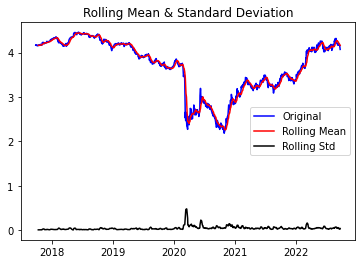

Results of Dickey-Fuller Test:
Test Statistic                   -1.485361
p-value                           0.540740
#Lags Used                       16.000000
Number of Observations Used    1242.000000
Critical Value (1%)              -3.435626
Critical Value (5%)              -2.863870
Critical Value (10%)             -2.568010
dtype: float64


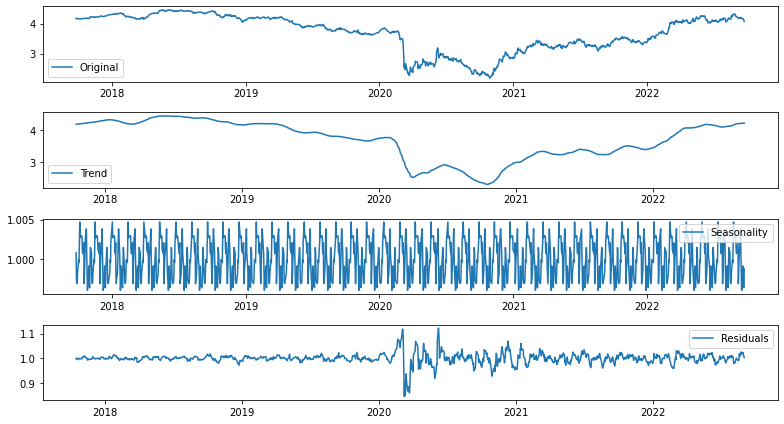

In [8]:
# rolling stats graph
plot_rolling_statistics(ts2_log, window=12)

# ADF Test
augmented_dickey_fuller_test(ts2_log)

# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose # for time series decomposition
                                                         # can view trend and seasonality separately

decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30)

trend = decomposition.trend # trend = change of mean vals through time
                            # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # seasonality = periodic change without pattern
                                  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # residual = original(log scaled) - trend - seasonality
                               # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# prior to log scaling, p-value was 0.59
# after log scaling, p-value is 0.54

In [9]:
# Confiming residual stationarity
residual = residual.dropna()
augmented_dickey_fuller_test(residual)
residual

Results of Dickey-Fuller Test:
Test Statistic                -1.022464e+01
p-value                        5.215644e-18
#Lags Used                     1.700000e+01
Number of Observations Used    1.211000e+03
Critical Value (1%)           -3.435761e+00
Critical Value (5%)           -2.863930e+00
Critical Value (10%)          -2.568042e+00
dtype: float64


Date
2017-10-16    0.997173
2017-10-17    1.001292
2017-10-18    0.999376
2017-10-19    0.997980
2017-10-20    0.997504
                ...   
2022-08-26    1.018907
2022-08-29    1.023450
2022-08-30    1.012712
2022-08-31    1.009438
2022-09-01    1.002858
Name: resid, Length: 1229, dtype: float64

### Splitting train-test sets

Date
2017-09-25    4.167905
2017-09-26    4.165735
Name: Close, dtype: float64
(1133,)
(126,)


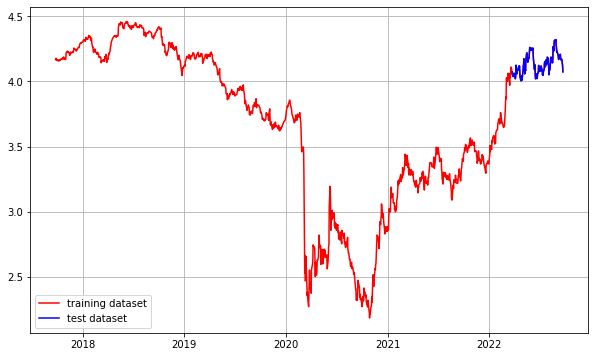

In [10]:
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # ts2_log used instead of train_data for a smooth graph
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

print(ts2_log[:2])
print(train_data.shape)
print(test_data.shape)

### Finding adequate ARIMA parameters

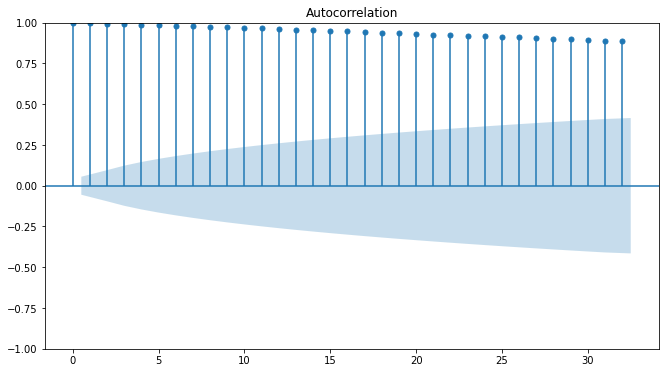

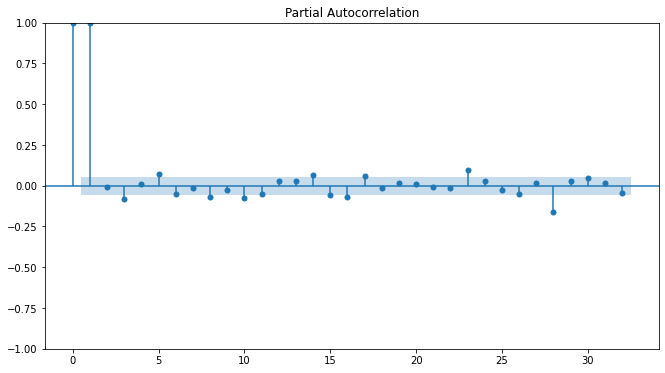

In [11]:
# ACF, PACF plotting -> to find p,q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation plot
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation plot
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.216824e+00
p-value                        6.589845e-13
#Lags Used                     1.500000e+01
Number of Observations Used    1.242000e+03
Critical Value (1%)           -3.435626e+00
Critical Value (5%)           -2.863870e+00
Critical Value (10%)          -2.568010e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.200745e+01
p-value                        3.239045e-22
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


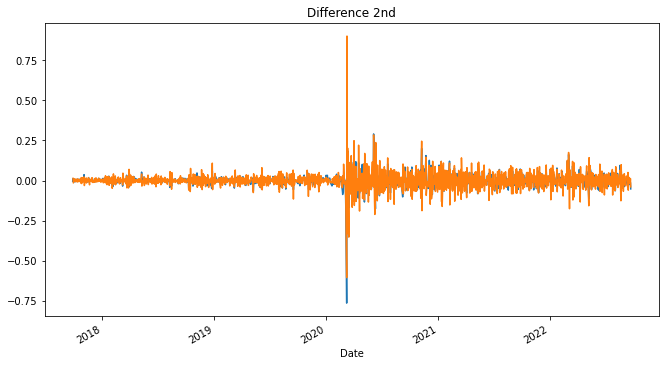

In [12]:
# Differential stationarity -> finding parameter 'd'
# 1st differential
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2nd differential
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Train-test ARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 6)) # Refer to ACF, PACF, and Differential
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 2, 6)   Log Likelihood                1963.674
Date:                Fri, 30 Sep 2022   AIC                          -3911.348
Time:                        14:03:09   BIC                          -3871.101
Sample:                             0   HQIC                         -3896.143
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8903      0.070    -12.642      0.000      -1.028      -0.752
ma.L1         -0.1042      0.071     -1.470      0.141      -0.243       0.035
ma.L2         -0.8236      0.071    -11.578      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


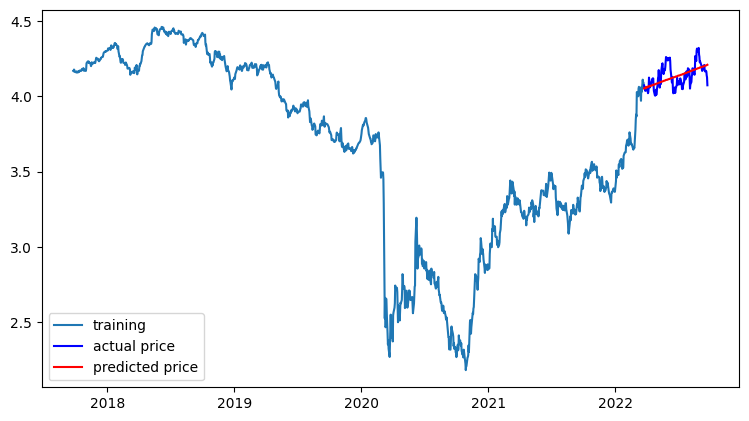

In [14]:
# Forecast : return forecast to variable 'fc' 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # fc result

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
# calculating mse, mae, rmse, and mape
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18.473335281838263
MAE:  3.367693131924911
RMSE:  4.298061805260397
MAPE: 5.28%


# 2nd stock - Tesla (TSLA)

In [16]:
# load file
tsla_path = 'TSLA.csv'
df = pd.read_csv(tsla_path, index_col = 'Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-25,23.543333,23.831333,22.858667,22.999332,22.999332,114088500
2017-09-26,23.395332,23.416000,22.726667,23.016666,23.016666,107344500
2017-09-27,23.326668,23.432667,22.700001,22.731333,22.731333,90904500
2017-09-28,22.658667,22.850000,22.360001,22.639999,22.639999,79794000
2017-09-29,22.790667,22.978666,22.573334,22.740000,22.740000,76606500
...,...,...,...,...,...,...
2022-09-19,300.089996,309.839996,297.799988,309.070007,309.070007,60231200
2022-09-20,306.910004,313.329987,305.579987,308.730011,308.730011,61642800
2022-09-21,308.290009,313.799988,300.630005,300.799988,300.799988,62555700


In [17]:
# assigning close col from df
ts3 = df['Close']
ts3

Date
2017-09-25     22.999332
2017-09-26     23.016666
2017-09-27     22.731333
2017-09-28     22.639999
2017-09-29     22.740000
                 ...    
2022-09-19    309.070007
2022-09-20    308.730011
2022-09-21    300.799988
2022-09-22    288.589996
2022-09-23    275.329987
Name: Close, Length: 1259, dtype: float64

### Preprocessing

In [18]:
# in case there are any null vals, interpolate null vals using time as a method
ts3 = ts3.interpolate(method='time')
ts3[ts3.isna()]

Series([], Name: Close, dtype: float64)

In [19]:
# log scale time series data
ts3_log = np.log(ts3)
ts3_log

Date
2017-09-25    3.135465
2017-09-26    3.136219
2017-09-27    3.123744
2017-09-28    3.119718
2017-09-29    3.124125
                ...   
2022-09-19    5.733568
2022-09-20    5.732467
2022-09-21    5.706446
2022-09-22    5.665007
2022-09-23    5.617970
Name: Close, Length: 1259, dtype: float64

### Stationary analysis

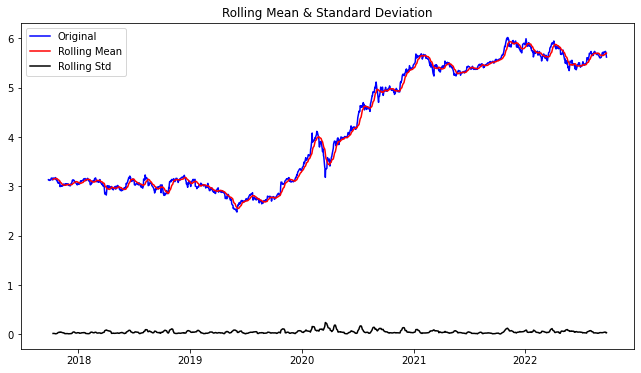

Results of Dickey-Fuller Test:
Test Statistic                   -0.285314
p-value                           0.927559
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


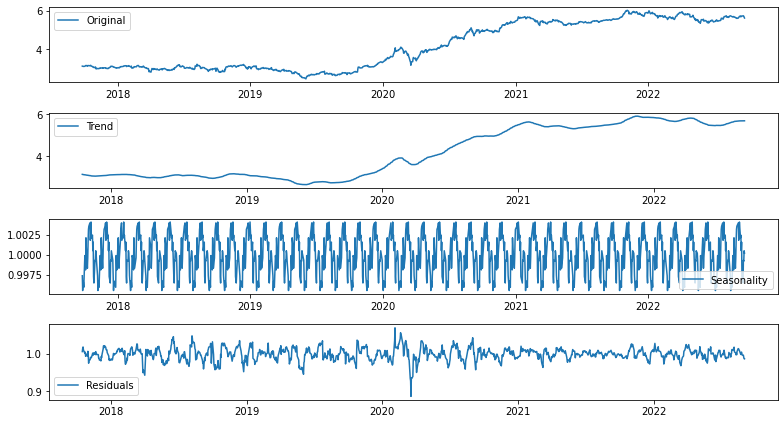

In [20]:
# rolling stats graph
plot_rolling_statistics(ts3_log, window=12)

# ADF Test
augmented_dickey_fuller_test(ts3_log)

# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose # for time series decomposition
                                                         # can view trend and seasonality separately

decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30)

trend = decomposition.trend # trend = change of mean vals through time
                            # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # seasonality = periodic change without pattern
                                  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # residual = original(log scaled) - trend - seasonality
                               # 오리지날(로그) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [21]:
# Confiming residual stationarity
residual = residual.dropna()
augmented_dickey_fuller_test(residual)
residual

Results of Dickey-Fuller Test:
Test Statistic                -1.058500e+01
p-value                        6.752369e-19
#Lags Used                     1.800000e+01
Number of Observations Used    1.210000e+03
Critical Value (1%)           -3.435766e+00
Critical Value (5%)           -2.863932e+00
Critical Value (10%)          -2.568043e+00
dtype: float64


Date
2017-10-16    1.006177
2017-10-17    1.014402
2017-10-18    1.018522
2017-10-19    1.011010
2017-10-20    1.008122
                ...   
2022-08-26    0.996469
2022-08-29    0.996666
2022-08-30    0.990561
2022-08-31    0.986989
2022-09-01    0.986720
Name: resid, Length: 1229, dtype: float64

### Splitting train-test sets

Date
2017-09-25    3.135465
2017-09-26    3.136219
Name: Close, dtype: float64
(1133,)
(126,)


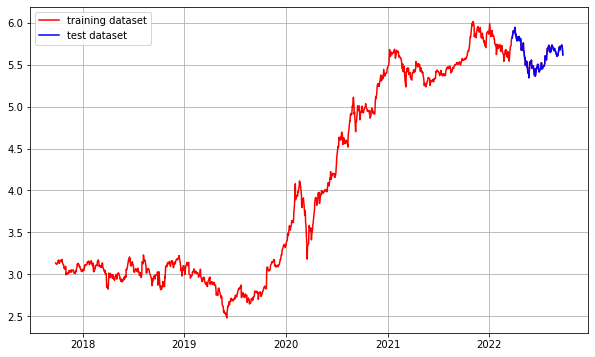

In [22]:
# split time series into train set and test set
train_data, test_data = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # ts2_log used instead of train_data for a smooth graph
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

print(ts3_log[:2])
print(train_data.shape)
print(test_data.shape)

### Fining adequate ARIMA parameters

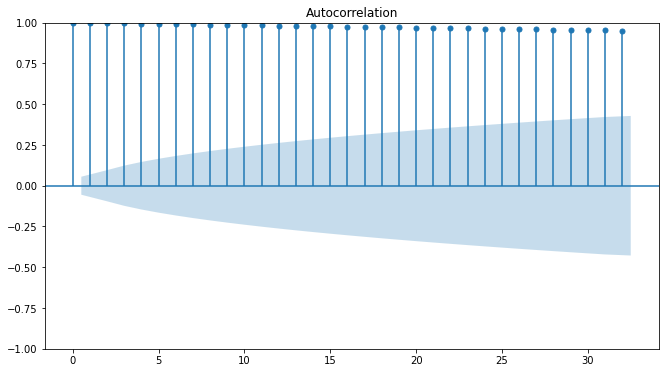

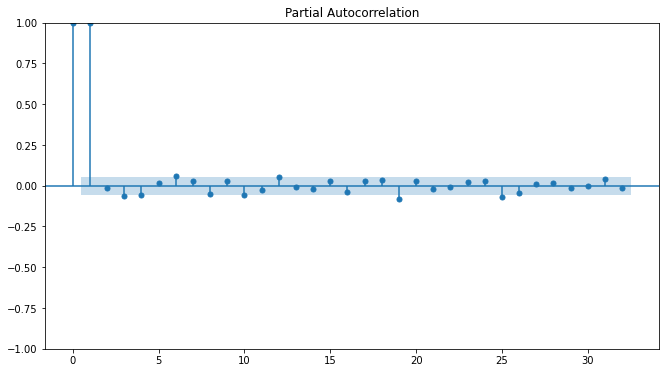

In [23]:
# ACF, PACF plotting -> to find p,q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)   # ACF : Autocorrelation plot
plot_pacf(ts3_log)  # PACF : Partial Autocorrelation plot
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.313641e+01
p-value                        1.459079e-24
#Lags Used                     6.000000e+00
Number of Observations Used    1.251000e+03
Critical Value (1%)           -3.435588e+00
Critical Value (5%)           -2.863853e+00
Critical Value (10%)          -2.568002e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.239728e+01
p-value                        4.644703e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


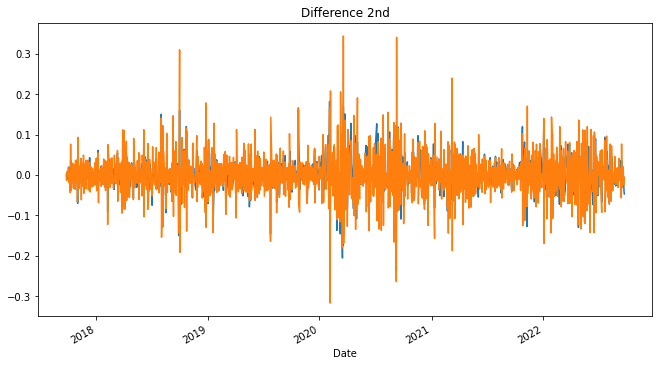

In [40]:
# Differential stationarity -> finding parameter 'd'
# 1st differential
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2nd differential
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Train-test ARIMA

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(3, 0, 7)) # Refer to ACF, PACF, and Differential plots
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(3, 0, 7)   Log Likelihood                2033.649
Date:                Fri, 30 Sep 2022   AIC                          -4043.297
Time:                        14:03:20   BIC                          -3982.906
Sample:                             0   HQIC                         -4020.484
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0203      0.720      5.585      0.000       2.610       5.431
ar.L1         -0.5661      0.307     -1.844      0.065      -1.168       0.036
ar.L2          0.7473      0.186      4.018      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


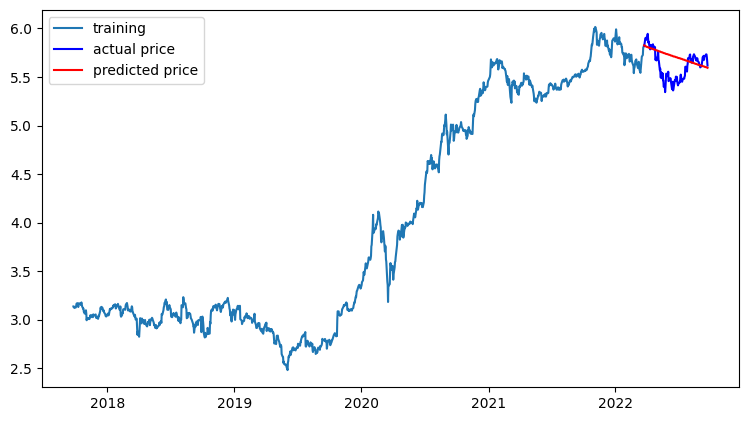

In [26]:
# Forecast : return forecast to variable 'fc' 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # fc result

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
# calculating mse, mae, rmse, and mape
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2111.6891327648764
MAE:  37.072221111458376
RMSE:  45.95311885786292
MAPE: 14.72%


# 3rd stock - Game Stop (GME)

In [28]:
# load file
gme_path = 'GME.csv'
df = pd.read_csv(gme_path, index_col = 'Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-25,5.007500,5.1175,5.002500,5.110000,4.377719,4635200
2017-09-26,5.137500,5.1925,5.085000,5.162500,4.422696,8520400
2017-09-27,5.195000,5.2425,5.125000,5.212500,4.465531,8193600
2017-09-28,5.202500,5.2325,5.152500,5.197500,4.452681,6883600
2017-09-29,5.200000,5.2125,5.130000,5.165000,4.424838,6262800
...,...,...,...,...,...,...
2022-09-19,28.340000,29.6500,28.150000,28.959999,28.959999,3404000
2022-09-20,29.280001,29.3300,27.180000,27.540001,27.540001,3145900
2022-09-21,27.450001,28.9900,26.770000,26.860001,26.860001,3859200


In [29]:
# assigning close col from df
ts4 = df['Close']
ts4

Date
2017-09-25     5.110000
2017-09-26     5.162500
2017-09-27     5.212500
2017-09-28     5.197500
2017-09-29     5.165000
                ...    
2022-09-19    28.959999
2022-09-20    27.540001
2022-09-21    26.860001
2022-09-22    24.700001
2022-09-23    25.040001
Name: Close, Length: 1259, dtype: float64

### Preprocessing

In [30]:
# in case there are any null vals, interpolate null vals using time as a method
ts4 = ts4.interpolate(method='time')
ts4[ts4.isna()]

Series([], Name: Close, dtype: float64)

In [31]:
# log scale time series data
ts4_log = np.log(ts4)
ts4_log

Date
2017-09-25    1.631199
2017-09-26    1.641421
2017-09-27    1.651060
2017-09-28    1.648178
2017-09-29    1.641905
                ...   
2022-09-19    3.365916
2022-09-20    3.315640
2022-09-21    3.290638
2022-09-22    3.206803
2022-09-23    3.220475
Name: Close, Length: 1259, dtype: float64

### Stationary analysis

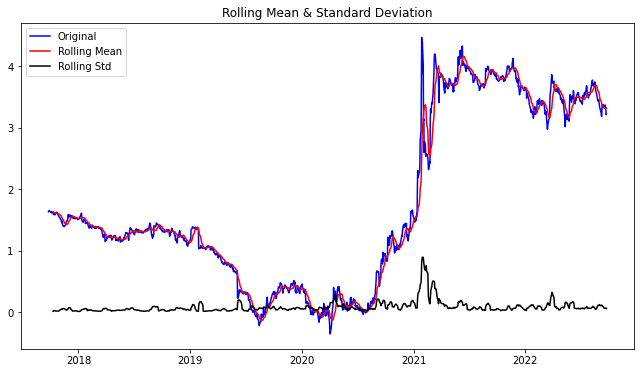

Results of Dickey-Fuller Test:
Test Statistic                   -0.395073
p-value                           0.910918
#Lags Used                       16.000000
Number of Observations Used    1242.000000
Critical Value (1%)              -3.435626
Critical Value (5%)              -2.863870
Critical Value (10%)             -2.568010
dtype: float64


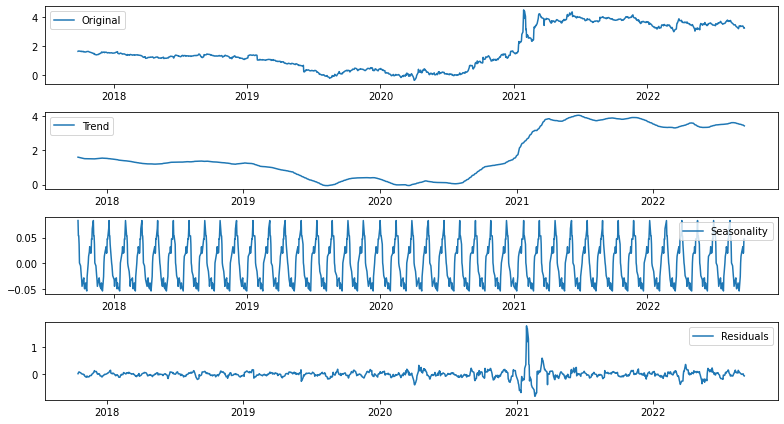

In [32]:
# rolling stats graph
plot_rolling_statistics(ts4_log, window=12)

# ADF Test
augmented_dickey_fuller_test(ts4_log)

# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose # for time series decomposition
                                                         # can view trend and seasonality separately

decomposition = seasonal_decompose(ts4_log, model='additive', period=30)

trend = decomposition.trend # trend = change of mean vals through time
                            # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal # seasonality = periodic change without pattern
                                  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # residual = original(log scaled) - trend - seasonality
                               # 오리지날(로그) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts4_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [33]:
# Confiming residual stationarity
residual = residual.dropna()
augmented_dickey_fuller_test(residual)
residual

Results of Dickey-Fuller Test:
Test Statistic                -1.156751e+01
p-value                        3.160101e-21
#Lags Used                     2.200000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64


Date
2017-10-16    0.019696
2017-10-17    0.044736
2017-10-18    0.077238
2017-10-19    0.085513
2017-10-20    0.068163
                ...   
2022-08-26   -0.005740
2022-08-29    0.015703
2022-08-30   -0.028882
2022-08-31   -0.056994
2022-09-01   -0.061012
Name: resid, Length: 1229, dtype: float64

### Splitting train-test sets

Date
2017-09-25    1.631199
2017-09-26    1.641421
Name: Close, dtype: float64
(1133,)
(126,)


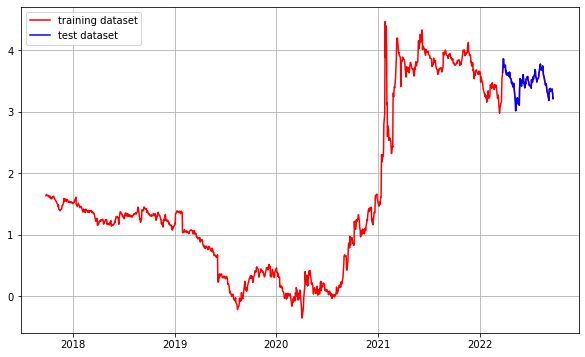

In [34]:
# splitting time series into train set and test set
train_data, test_data = ts4_log[:int(len(ts4_log)*0.9)], ts4_log[int(len(ts4_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts4_log, c='r', label='training dataset')  # ts2_log used instead of train_data for a smooth graph
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

print(ts4_log[:2])
print(train_data.shape)
print(test_data.shape)

### Fining adequate ARIMA parameters

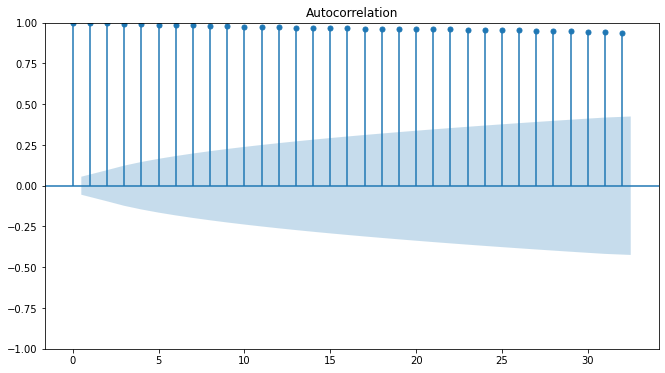

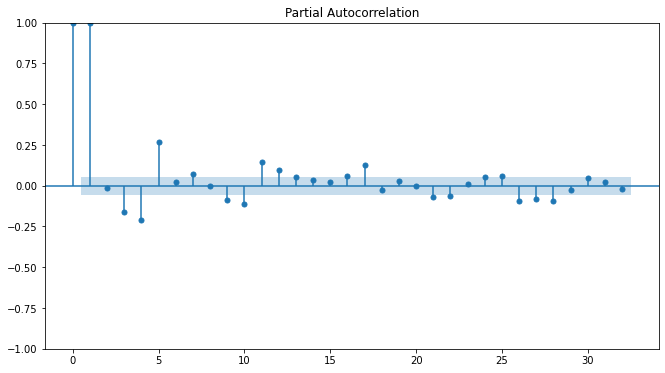

In [35]:
# ACF, PACF plotting -> to find p,q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts4_log)   # ACF : Autocorrelation plot
plot_pacf(ts4_log)  # PACF : Partial Autocorrelation plot
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.183902e+01
p-value                        7.668236e-22
#Lags Used                     1.500000e+01
Number of Observations Used    1.242000e+03
Critical Value (1%)           -3.435626e+00
Critical Value (5%)           -2.863870e+00
Critical Value (10%)          -2.568010e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.366993e+01
p-value                        1.466288e-25
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


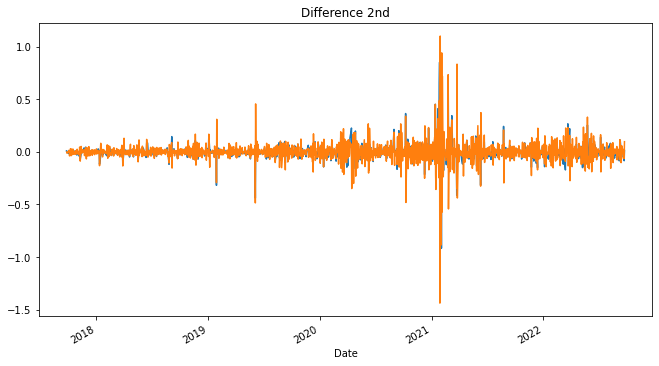

In [36]:
# Differential stationarity -> finding parameter 'd'
# 1st differential
diff_1 = ts4_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2nd differential
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Train-test ARIMA

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 4)) # Refer to ACF, PACF, and Differential plots
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 0, 4)   Log Likelihood                1246.877
Date:                Fri, 30 Sep 2022   AIC                          -2479.754
Time:                        14:03:25   BIC                          -2444.526
Sample:                             0   HQIC                         -2466.446
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1669      2.212      0.980      0.327      -2.169       6.503
ar.L1          0.9986      0.002    535.444      0.000       0.995       1.002
ma.L1          0.0369      0.010      3.884      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


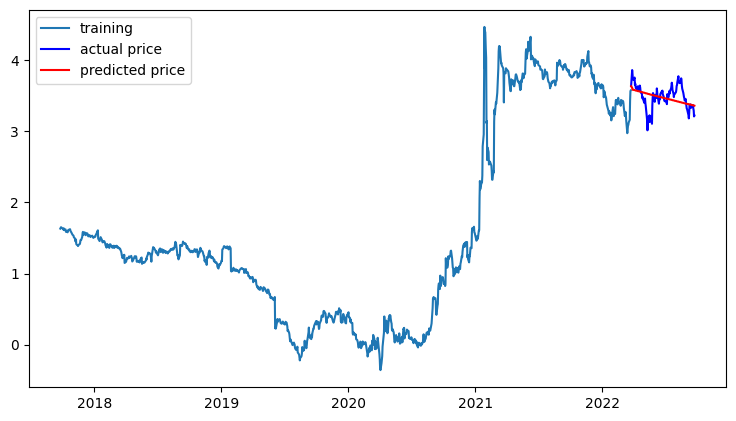

In [38]:
# Forecast : return forecast to variable 'fc' 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # fc result

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
# calculating mse, mae, rmse, and mape
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  29.092226866580297
MAE:  4.078941973655024
RMSE:  5.3937210593967775
MAPE: 12.95%


# 회고

- 지금와서 생각해보면 연관성이 전혀 없는데, 주식을 좋아한다는 이유 하나만으로 주식=쉽다=이번 노드 라는 생각의 흐름에 크게 낭패를 봤다.
- 시계열 데이터 예측학습에 3개의 학습목표가 있었고 이 3개를 대부분 이해하여 전체적인 컨셉은 이해했다고 할 수 있지만, 아쉽게도 세부적인 내용들을 완벽히 이해하기가 힘들었다.
- 특히나 어려웠던 점은 ARIMA모델에 p, d, q 값을 것이었다. 당연히 특정숫자만 골라서 원하는 결과를 얻는 것이 불가능했다.
- 그래도 조금이나마 이해를 하여 실제 주식 3종목을 정하고 예측값을 찾아봤을 때 공통적으로 PACF그래프가 특정 시차이후 0으로 급격히 떨어져, p 숫자를 정할수 있었다.
- 노드에서 배운대로 내가 사용했던 주식 종목들에 q값을 처음에는 0으로 맞추고 돌려봤지만 기준치에 못 미쳐서, q값을 하나씩 올리는 전사적 방법을 통해 기준치에 맞는 값을 찾았다.
- d 값은 먼저 안정성을 띠는지 차분을 이용해 확인을 하였고 알맞은 값을 넣어 모델로 예측을 해보았다.
- 주식은 시간뿐만이 아니라 다른 요소들에도 영향을 받기에 시계열 데이터로만 예측하는 것은 당연히 위험한 생각이다.
    - 마켓을 그저 따라가는 것이 시계열 데이터만을 이용하는 것보다 훨씬 나은 결과를 보여줌을 확신한다.

## 신기/이상한 점

- d가 3이상이라면 데이터 자체가 정상성을 전혀 띠지 않아서 모델을 돌리지 못한다는 것을 배웠다.
- 주식(1) 이 안정성을 띠는 경향이라면 p, d, q 값을 ACF, PACF, Differencing으로 확인 후 비슷하게 맞는 값을 유추해 보는게 가능했다
- 반대로 안정성을 띠지 않는 주식(2 & 3) 같은 경우는 d값을 0으로, 한마디로 차분을 전혀 하지 않았을 때, 기준치에 미치는 값을 보였다
    - 안정성을 띠지 않는 주식: 공매도/뉴스 등등 외압에 쉽게 휩쓸리며 주식가가 크게 변동하는 주식을 표현
    - 배운것을 토대로 생각했을 때는 특히나 안정적이지 않은 주식들 d를 최대 2-3으로 올리며 안정성을 확인하고 모델에 적용하는 것으로 이해했는데, 실제로는 반대로 d를 0으로 둬야 원하는 근사값이 나오니 이상했다.
    - 다만 차분 그래프를 보며 유추한 바로는 불안정한 주식들은 차분을 하면 할 수록 전체 데이터가 안정적으로 바뀌는 폭에 비해 높낮이 폭이 많이 커지는 것을 볼 수 있었다. 그래서 차분을 하면 안된다는 생각이 들었었다.
    - 또는 이미 residual이 모델이 보기엔 안정적이라서 차분을 하는 의미가 없기에 0으로 두는 것일 수도 있겠다는 생각이 들었다.
    - 아쉽게도 인터넷으로 찾아봤지만 이것에 대해 찾지를 못하여 유추만 해볼수 있었다

## 궁금/추가 공부

1. ARIMA모델에 사용되는 모수 p, d, q 정확한 숫자 정하는 법
    - 특히 주식 데이터에 따라 d(차분) 정하는 것
2. 시계열 데이터만으로 예측이 불가능한 상황에 어떻게 다른 요소를 집어 넣어 실제로 예측할 수 있을까?